In [20]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import edhec_risk_kit as erk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ind = erk.get_ind_returns()
er = erk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

In [4]:
l = ["fin", "beer"]
er[l].shape, cov.loc[l,l].shape

((2,), (2, 2))

In [5]:
from scipy.optimize import minimize

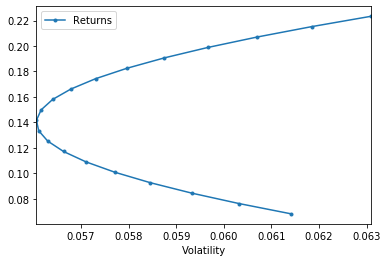

In [7]:
l = ["games", "fin"]
erk.plot_ef2(20, er[l], cov.loc[l,l])

## Goal 

How can I figure out the weights of the portfolio that gives me that X% return but gives me the lowest possible volatility?

**The minimization routine will Find a solution that:**
1. satisfies the bounds
2. satisfies the constraints
3. run the objective function
4. minimizes the value of the portfolio volatility
5. finds the weights that minimizes the volatility

In [10]:
((0.0, 1.0),)*3

((0.0, 1.0), (0.0, 1.0), (0.0, 1.0))

In [12]:
def minimize_vol(target_return, er, cov):
    """
    target_return -> W
    """
    # Number of assets
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    # Constraints
    # Weight bounds: minimum of 0 and maximum of 100%
    bounds = ((0.0, 1.0),)*n
    # Return generated from weights is the target_return
    return_is_target = {
        "type": "eq",
        "args": (er,),
        "fun": lambda weights, er: target_return - erk.portfolio_return(weights, er)
    }
    # Weights sum to 1
    weights_sum_to_1 = {
        "type": "eq",
        "fun": lambda weights: np.sum(weights) - 1
    }
    results = minimize(erk.portfolio_vol, init_guess,
                       args=(cov,), method="SLSQP",
                       options={"disp": False},
                       constraints=(return_is_target, weights_sum_to_1),
                       bounds=bounds)
    return results.x

In [13]:
l

['games', 'fin']

In [17]:
# Find the portfolio that has a target return of 15%
# given these expected returns and covariance matrix
w15 = minimize_vol(0.15, er[l], cov.loc[l, l])
vol15 = erk.portfolio_vol(w15, cov.loc[l,l])
vol15

0.056163669406706564

In [18]:
w15

array([0.47287631, 0.52712369])

In [23]:
erk.minimize_vol(0.15, er[l], cov.loc[l,l])

array([0.47287631, 0.52712369])

In [27]:
def optimal_weights(n_points, er, cov):
    """
    -> list of weights to run the optimizer on to minimize the vol
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights


def plot_ef(n_points, er, cov, style=".-"):
    """
    Plots the N-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [erk.portfolio_return(w, er) for w in weights]
    vols = [erk.portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=style)

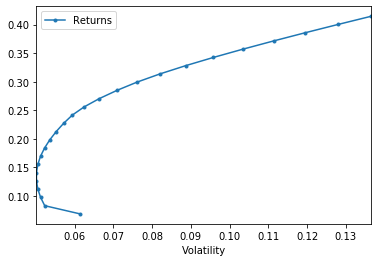

In [28]:
l = ["smoke", "fin", "games", "coal"]
plot_ef(25, er[l], cov.loc[l,l])

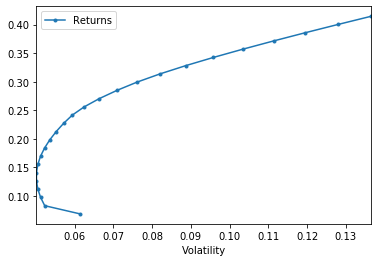

In [29]:
l = ["smoke", "fin", "games", "coal"]
erk.plot_ef(25, er[l], cov.loc[l,l])